In [8]:
##################################
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd 
import numpy as np
import random
##################################

In [9]:
df = pd.read_csv("bank.csv")
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no


In [10]:
job = [ "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown"]

for ii in range(len(job)): 
    df.job[df.job == job[ii]] = ii

marital = ["divorced","married","single","unknown"]

for ii in range(len(marital)):
    df.marital[df.marital == marital[ii]] = ii

education =  ["primary","secondary","tertiary","unknown"]

for ii in range(len(education)):
    df.education[df.education == education[ii]] = ii

df.default[df.default == "no" ] = 0
df.default[df.default == "yes" ] = 1

df.housing[df.housing == "no" ] = 0
df.housing[df.housing == "yes" ] = 1

df.loan[df.loan == "no" ] = 0
df.loan[df.loan == "yes" ] = 1

contact = ["telephone","cellular","unknown"] 

for ii in range(len(contact)):
    df.contact[df.contact == contact[ii]] = ii

month = ["jan", "feb", "mar", "apr", "may","jun", "jul", "aug", "sep", "oct","nov", "dec"]

for ii in range(len(month)):
    df.month[df.month == month[ii]] = ii

poutcome = ["other","failure","success", "unknown"]


for ii in range(len(poutcome)):
    df.poutcome[df.poutcome == poutcome[ii]] = ii

df.y[df.y == "no" ] = 0
df.y[df.y == "yes" ] = 1

<ipython-input-10-3dfb5d4b2e70>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.job[df.job == job[ii]] = ii
<ipython-input-10-3dfb5d4b2e70>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.marital[df.marital == marital[ii]] = ii
<ipython-input-10-3dfb5d4b2e70>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.education[df.education == education[ii]] = ii
<ipython-input-10-3dfb5d4b2e70>:16: SettingWithCopyWarning: 
A value is 

In [11]:
sampled = df.sample(1000)
sampled.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
796,38,7,0,1,0,792,0,0,2,6,5,430,1,-1,0,3,0
3797,30,9,2,2,0,2325,0,0,1,5,3,270,3,241,4,0,0
2098,57,5,1,1,1,32,1,0,1,15,4,476,3,-1,0,3,0
2282,44,1,2,0,0,787,1,0,2,30,4,570,2,-1,0,3,0
822,40,6,1,2,0,13669,0,0,1,15,9,138,1,136,8,0,0


[0.09751095 0.06237184 0.04629354 0.0529843  0.00540449 0.09172728
 0.02003791 0.01131905 0.04001011 0.08271266 0.08901176 0.23460531
 0.0590884  0.03859124 0.03266605 0.03566511]


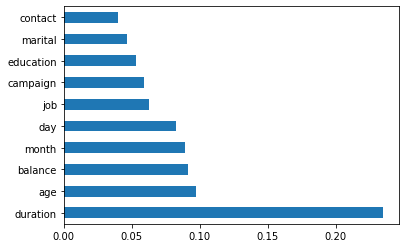

In [12]:

x = sampled.iloc[:, 0:16]
y = sampled.iloc[:, -1]
y = y.astype('int')

from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(x, y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [13]:
new_df = np.array(sampled[['duration','month','day','age','balance']])
new_df

array([[118, 5, 17, 46, 538],
       [122, 3, 20, 50, 3924],
       [92, 6, 23, 45, 295],
       ...,
       [476, 4, 15, 57, 32],
       [570, 4, 30, 44, 787],
       [138, 9, 15, 40, 13669]], dtype=object)

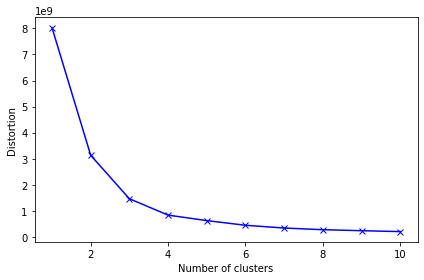

In [14]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i)
    km.fit(new_df)
    distortions.append(km.inertia_)
plt.plot(range(1, 11), distortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()

plt.show()